## Part 1: Preprocessing Data

In [1]:
import pandas as pd

path = 'C:/Users/2093/Desktop/Data Center/03. Data/06. companies/財政部廠商進出口資料/KMG_HS6COUNTRY.csv'
df = pd.read_csv(path, names=['ban', 'code', 'country', 'year', 'month', 'ex', 'im'], header=0,
                 dtype={'ban': str, 'code': str, 'country': str, 'year': str, 'month': str,
                        'ex': int, 'im': int})
# Remove yearly total rows
df = df[df['month'].notnull()]
# Pad zeros and construct DatetimeIndex
df['month'] = df['month'].apply(lambda x: x.zfill(2))
df.index = pd.to_datetime(df['year'] + df['month'], format='%Y%m')
df.index.name = 'date'
# Drop original year and month columns
df = df.drop(['year', 'month'], axis=1)

## Part 2: Export Commodity Summary Statistics

In [2]:
import numpy as np

n_codes = np.mean([len(df.loc['2014', :]['code'].unique()), len(df.loc['2015', :]['code'].unique())])
print('臺灣一年平均進出口{:,.0f}種HS6產品。'.format(n_codes))

臺灣一年平均進出口5,262種HS6產品。


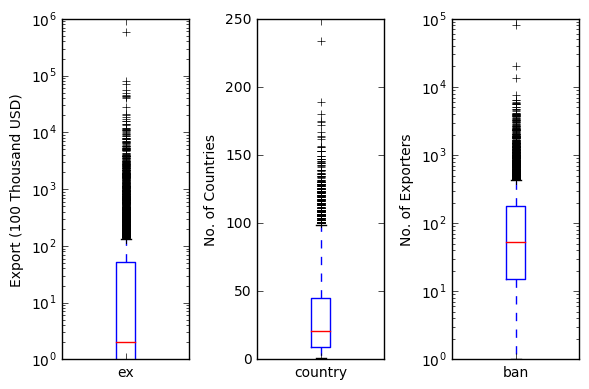

count      5246.000000
mean        440.575677
std        8587.281250
min           0.000000
25%           0.000000
50%           2.000000
75%          53.000000
max      594553.000000
Name: ex, dtype: float64

單一產品之出口額中位數為20萬美元，平均值則達4,406萬美元，二者落差極大，顯示離群值有非常大的影響力。
其中金額最大者為854239(積體電路)。

count    5246.000000
mean       31.627716
std        31.341089
min         1.000000
25%         9.000000
50%        21.000000
75%        45.000000
max       234.000000
Name: country, dtype: float64

平均每種產品出口至32個國家。
除了989900(旅客攜帶之應稅零星物品)外，出口至最多國家(189國)的產品是392690(其他塑膠製品)。

count     5246.000000
mean       233.629623
std       1275.404845
min          1.000000
25%         15.000000
50%         53.000000
75%        179.750000
max      81391.000000
Name: ban, dtype: float64

以中位數而言，每種產品有53家不重複的出口商。
扣除989900(旅客攜帶之應稅零星物品)，最多出口商的產品為392690(其他塑膠製品)，出口商達20,061家。


In [3]:
import matplotlib.pyplot as plt

code_stats = df.loc['2015', :].groupby(['code']).agg({'ex': 'sum', 'country': 'nunique', 'ban': 'nunique'})

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=3)
code_stats['ex'].plot(ax=axes[0], kind='box')
code_stats['country'].plot(ax=axes[1], kind='box')
code_stats['ban'].plot(ax=axes[2], kind='box')
axes[0].set_yscale('log')
axes[0].set_ylabel('Export (100 Thousand USD)')
axes[1].set_ylabel('No. of Countries')
axes[2].set_yscale('log')
axes[2].set_ylabel('No. of Exporters')
plt.tight_layout()
plt.show()

print(code_stats['ex'].describe())
print('\n單一產品之出口額中位數為{:.0f}萬美元，平均值則達{:,.0f}萬美元，二者落差極大，顯示離群值有非常大的影響力。\n'.format(
    code_stats['ex'].describe()['50%'] * 10, code_stats['ex'].describe()['mean'] * 10) +
    '其中金額最大者為{}(積體電路)。\n'.format(code_stats[code_stats['ex'] == code_stats['ex'].max()].index[0]))

print(code_stats['country'].describe())
print('\n平均每種產品出口至{:.0f}個國家。\n'.format(code_stats['country'].describe()['mean']) +
     '除了{}(旅客攜帶之應稅零星物品)外，出口至最多國家({}國)的產品是{}(其他塑膠製品)。\n'.format(
        code_stats[code_stats['country'] == code_stats['country'].max()].index[0],
        code_stats.sort_values(by='country', ascending=False)['country'][1],
        code_stats.sort_values(by='country', ascending=False).index[1]))

print(code_stats['ban'].describe())
print('\n以中位數而言，每種產品有{:.0f}家不重複的出口商。\n'.format(code_stats['ban'].describe()['50%']) +
    '扣除{}(旅客攜帶之應稅零星物品)，最多出口商的產品為{}(其他塑膠製品)，出口商達{:,}家。'.format(
        code_stats[code_stats['ban'] == code_stats['ban'].max()].index[0],
        code_stats.sort_values(by='ban', ascending=False).index[1],
        code_stats.sort_values(by='ban', ascending=False)['ban'][1]))

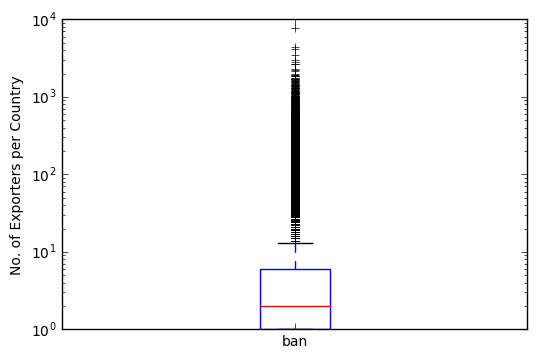

                 ban
count  165685.000000
mean       11.595666
std        57.372399
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      7802.000000

若是同時考慮自臺灣進口的國家別，則每種產品在每個國家約只有1至6家臺灣出口商。
其中最多臺灣出口商的組合為392690(其他塑膠製品)-CN(中國)，共7,802家。


In [4]:
code_stats_country = df.loc['2015', :].groupby(['code', 'country']).agg({'ban': 'nunique'}).drop(
    '989900', level='code')

plt.clf()
code_stats_country.plot(kind='box', logy=True)
plt.ylabel('No. of Exporters per Country')
plt.show()

print(code_stats_country.describe())
print('\n若是同時考慮自臺灣進口的國家別，則每種產品在每個國家約只有{:.0f}至{:.0f}家臺灣出口商。\n'.format(
    code_stats_country['ban'].describe()['25%'], code_stats_country['ban'].describe()['75%']) +
    '其中最多臺灣出口商的組合為{}(其他塑膠製品)-{}(中國)，共{:,.0f}家。'.format(
    code_stats_country[code_stats_country['ban'] == code_stats_country['ban'].max()].index[0][0],
    code_stats_country[code_stats_country['ban'] == code_stats_country['ban'].max()].index[0][1],
    code_stats_country['ban'].describe()['max']))

由下圖可看到，不同國家的每項產品平均出口商家數差異相當大。平均出口商家數最多的國家(地區)為：

國家(地區)	出口商家數
CN		94
JP		52
US		50
DE		30
HK		23


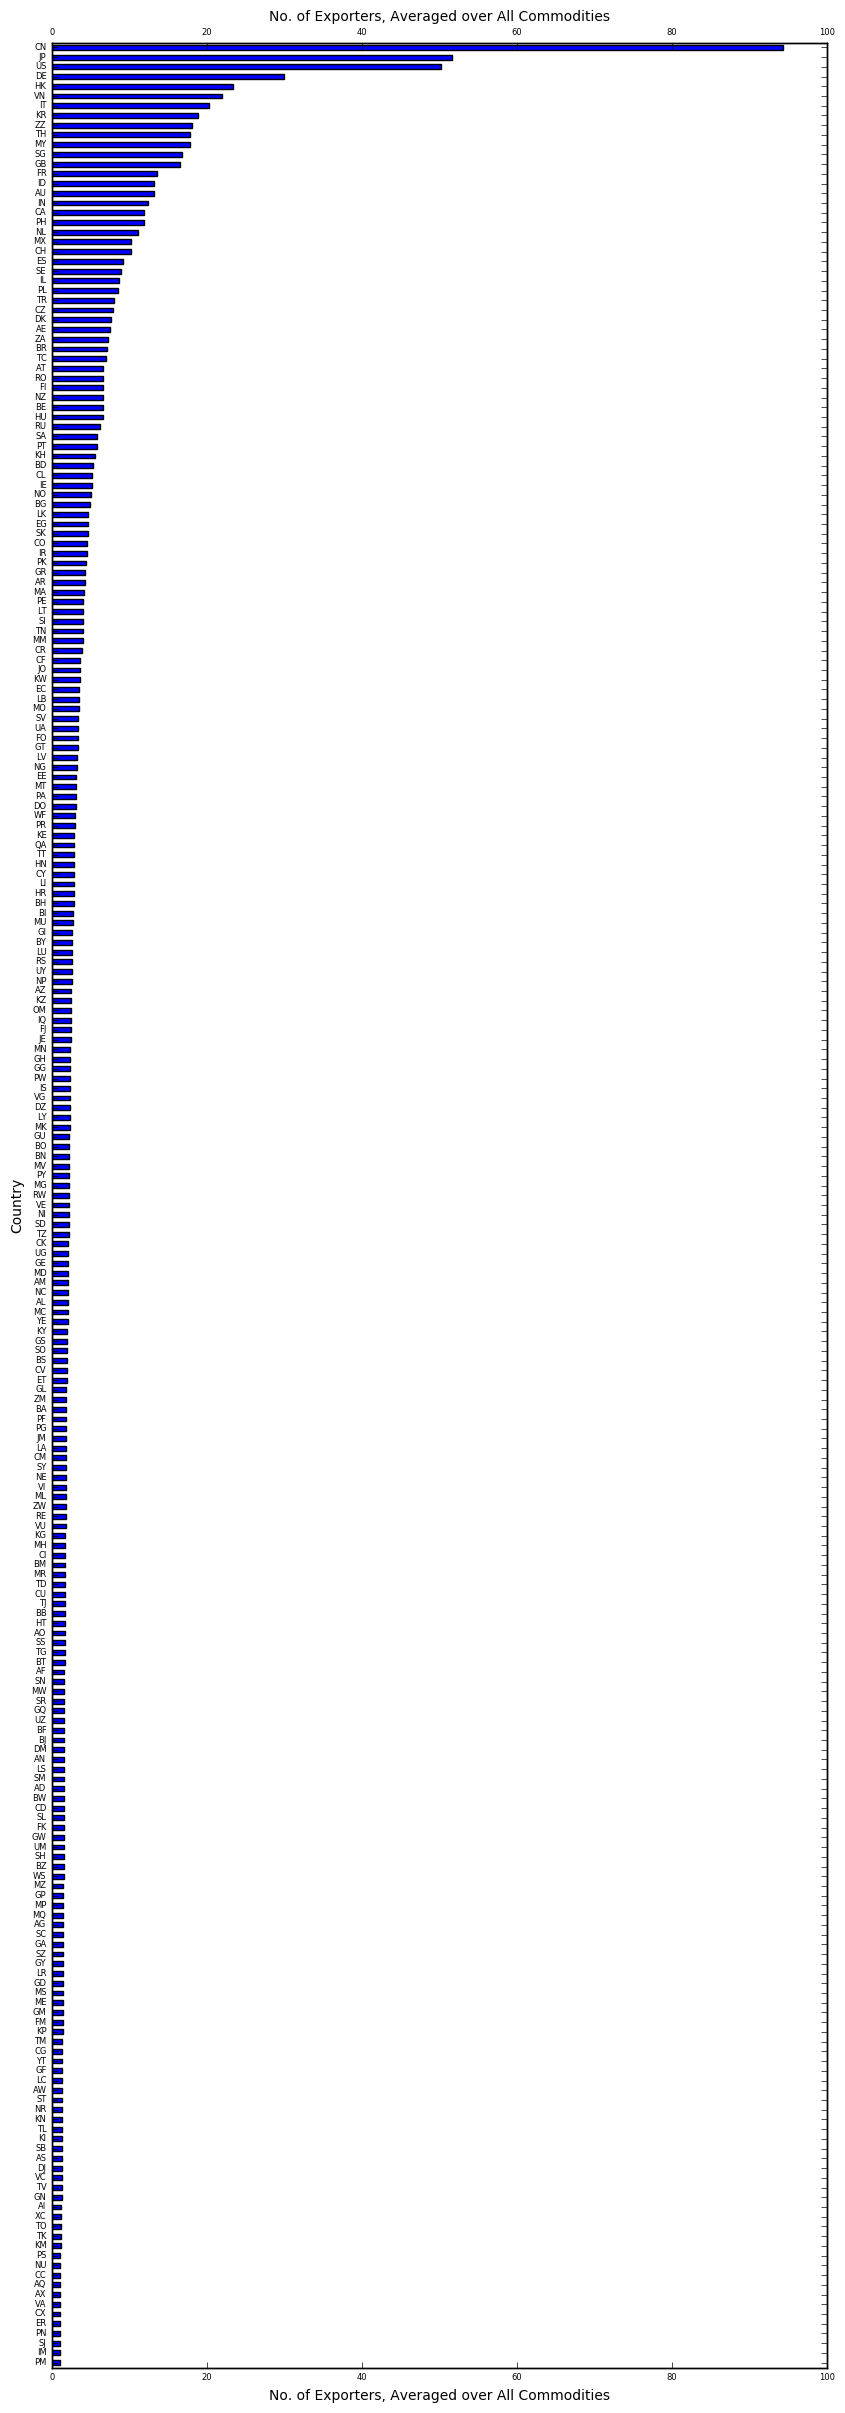

In [5]:
plt.clf()
code_stats_avg = df.loc['2015', :].groupby(['code', 'country']).agg({'ban': 'nunique'}).groupby(
    level='country').agg({'ban': 'mean'}).sort_values(by='ban')
ax1 = code_stats_avg.plot(kind='barh', fontsize=6, figsize=(10, 30), legend=None)
plt.xlabel('No. of Exporters, Averaged over All Commodities') 
plt.ylabel('Country')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.tick_params(labelsize=6)
ax2.set_xlabel('No. of Exporters, Averaged over All Commodities')

print('由下圖可看到，不同國家的每項產品平均出口商家數差異相當大。平均出口商家數最多的國家(地區)為：\n\n' +
    '國家(地區)\t出口商家數\n{}\t\t{:.0f}\n{}\t\t{:.0f}\n{}\t\t{:.0f}\n{}\t\t{:.0f}\n{}\t\t{:.0f}'.format(
    code_stats_avg.sort_values(by='ban', ascending=False).index[0],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][0],
    code_stats_avg.sort_values(by='ban', ascending=False).index[1],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][1],
    code_stats_avg.sort_values(by='ban', ascending=False).index[2],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][2],
    code_stats_avg.sort_values(by='ban', ascending=False).index[3],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][3],
    code_stats_avg.sort_values(by='ban', ascending=False).index[4],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][4]))
plt.show()

### 結論：每種產品有53家出口商，出口至32個國家。

## Part 3: Exporter Perspective Summary Statistics

In [6]:
print('臺灣共有{:,}家不重複的進出口商。'.format(len(df['ban'].unique())))

臺灣共有158,920家不重複的進出口商。


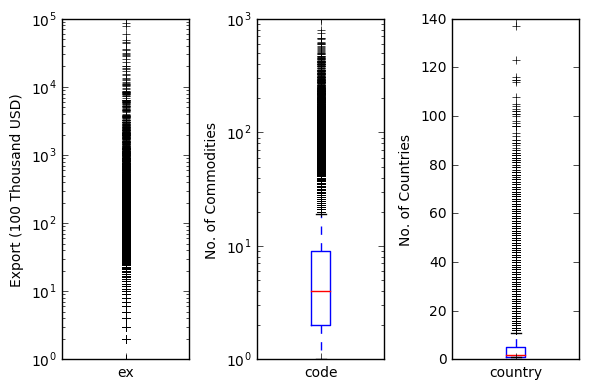

count    126179.000000
mean         18.317311
std         548.935852
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       87620.000000
Name: ex, dtype: float64

臺灣出口商年出口額的第三四分位數低於10萬美元，顯示多數出口商皆為小額出口。

count    126179.000000
mean          9.713352
std          21.840891
min           1.000000
25%           2.000000
50%           4.000000
75%           9.000000
max         992.000000
Name: code, dtype: float64

大多數廠商約出口2至9種產品，其中出口最多種產品的公司為29101436(凱洛爾科技有限公司)，共出口992種產品。

count    126179.000000
mean          4.496977
std           7.105947
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         137.000000
Name: country, dtype: float64

平均每家廠商出口至2個國家（中位數），出口至最多國家的公司為84117341(普萊德科技股份有限公司)，共137國。


In [7]:
com_stats = df.loc['2015', :].groupby(['ban']).agg({'code': 'nunique', 'country': 'nunique', 'ex': 'sum'})

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=3)
com_stats['ex'].plot(ax=axes[0], kind='box')
com_stats['code'].plot(ax=axes[1], kind='box')
com_stats['country'].plot(ax=axes[2], kind='box')
axes[0].set_yscale('log')
axes[0].set_ylabel('Export (100 Thousand USD)')
axes[1].set_yscale('log')
axes[1].set_ylabel('No. of Commodities')
axes[2].set_ylabel('No. of Countries')
plt.tight_layout()
plt.show()

print(com_stats['ex'].describe())
print('\n臺灣出口商年出口額的第三四分位數低於10萬美元，顯示多數出口商皆為小額出口。\n')

print(com_stats['code'].describe())
print('\n大多數廠商約出口{:.0f}至{:.0f}種產品，其中出口最多種產品的公司為{}(凱洛爾科技有限公司)，共出口{}種產品。\n'.format(
    com_stats['code'].describe()['25%'],
    com_stats['code'].describe()['75%'],
    com_stats[com_stats['code'] == com_stats['code'].max()].index[0],
    com_stats[com_stats['code'] == com_stats['code'].max()]['code'][0]))

print(com_stats['country'].describe())
print('\n平均每家廠商出口至{:.0f}個國家（中位數），出口至最多國家的公司為{}(普萊德科技股份有限公司)，共{}國。'.format(
    com_stats['country'].describe()['50%'],
    com_stats[com_stats['country'] == com_stats['country'].max()].index[0],
    com_stats[com_stats['country'] == com_stats['country'].max()]['country'][0]))

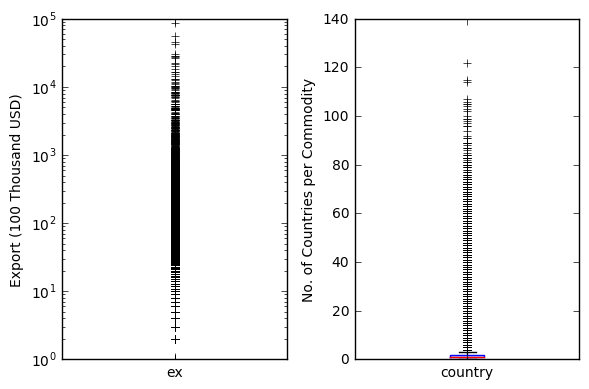

每家出口商「單一產品」的分布亦相當類似，但數字會再降低一些。


In [8]:
com_stats_code = df.loc['2015', :].groupby(['ban', 'code']).agg({'country': 'nunique', 'ex': 'sum'})

fig, axes = plt.subplots(nrows=1, ncols=2)
com_stats_code['ex'].plot(ax=axes[0], kind='box')
com_stats_code['country'].plot(ax=axes[1], kind='box')
axes[0].set_yscale('log')
axes[0].set_ylabel('Export (100 Thousand USD)')
axes[1].set_ylabel('No. of Countries per Commodity')
plt.tight_layout()
plt.show()

print('每家出口商「單一產品」的分布亦相當類似，但數字會再降低一些。')

### 結論：

In [9]:
tbl1 = pd.DataFrame({'視點': ['總體出口'],
                     '出口商數': ['{:,}'.format(len(df['ban'].unique()))],
                     '出口產品數': ['{:,}'.format(int(round(n_codes)))],
                     '出口國家數': [len(df['country'].unique())]})
tbl1[[3, 0, 2, 1]]

,視點,出口商數,出口產品數,出口國家數
0,總體出口,"158,920","5,262",245


In [10]:
tbl2 = pd.DataFrame({'視點': ['總體出口（單一產品）', '個體廠商', '個體廠商（單一產品）'],
                    '出口商數中位數': [code_stats['ban'].describe()['50%'], np.nan, np.nan],
                    '出口國家數25%': [code_stats['country'].describe()['25%'],
                                     com_stats['country'].describe()['25%'],
                                     com_stats_code['country'].describe()['25%']],
                    '出口國家數中位數': [code_stats['country'].describe()['50%'],
                                        com_stats['country'].describe()['50%'],
                                        com_stats_code['country'].describe()['50%']],
                    '出口國家數75%': [code_stats['country'].describe()['75%'],
                                     com_stats['country'].describe()['75%'],
                                     com_stats_code['country'].describe()['75%']]})
tbl2[[4, 0, 1, 3, 2]]

,視點,出口商數中位數,出口國家數25%,出口國家數中位數,出口國家數75%
0,總體出口（單一產品）,53.0,9.0,21.0,45.0
1,個體廠商,NaN,1.0,2.0,5.0
2,個體廠商（單一產品）,NaN,1.0,1.0,2.0
